In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import sys
sys.path.append('..')
from capacity_management.src.da import DeferredAcceptance
from capacity_management.src.mnl import MNL

In [3]:
n = 80 
q = 22
p = .1
t = 1/1000

In [4]:
q1hat = 1/(1-p) * (q - np.sqrt(q*p*(1-p)*2*np.log(3/t)))

In [5]:
q1hat

18.188068381431158

In [26]:
priorities = np.outer(np.random.uniform(size=n), np.ones(3))

In [28]:
utilities = np.tile([6,5,4], (n,1))
mnl = MNL(utilities, num_students=n)
preferences = mnl.sample_preference_ordering()

In [29]:
da = DeferredAcceptance(preferences,priorities,np.array([22,22,22]))
assignment = da.da()
assignment

{0: array([24, 51, 39, 14, 48, 21, 64, 73, 16, 71,  5, 70,  7, 10, 22,  8, 69,
        23, 55, 19, 58, 72]),
 1: array([74, 37,  0, 32, 36, 56, 79, 75, 68, 44, 62, 43, 63, 61, 54, 11, 35,
        33, 18, 47, 53,  9]),
 2: array([34, 12, 66, 15, 41,  3, 30, 28,  2, 59, 31, 78, 49, 76, 46, 38, 52,
        13, 29, 67, 50, 40])}

In [30]:
def simulate_dropout(assignment):
    after_dropout = {}
    leaving_list = []
    for school, students in assignment.items():
        leaving = np.array(np.random.binomial(size=len(students), n=1, p=p), dtype=bool)
        after_dropout[school] = students[~leaving]
        leaving_list = np.append(leaving_list, students[leaving])
    return after_dropout, leaving_list
        

In [31]:
after_dropout, leaving = simulate_dropout(assignment)
after_dropout

{0: array([24, 51, 14, 48, 21, 64, 73, 71,  5, 70,  7, 10, 22,  8, 69, 23, 55,
        19, 58]),
 1: array([74, 37,  0, 32, 36, 56, 79, 75, 68, 44, 62, 43, 61, 54, 11, 35, 33,
        47, 53,  9]),
 2: array([34, 12, 66, 15, 41,  3, 30, 28,  2, 59, 31, 78, 49, 76, 46, 38, 29,
        67, 50, 40])}

In [32]:
leaving

array([39., 16., 72., 63., 18., 52., 13.])

In [33]:
def get_rank_of_school(students, school, preferences):
    return np.argwhere(preferences[students,:]==school)[:,1]

In [34]:
prefer_other_idx = np.argwhere(np.argwhere(preferences[after_dropout[0],:]==0)[:,1]-np.argwhere(preferences[after_dropout[0],:]==1)[:,1]>0).flatten()
prefer_other = after_dropout[0][prefer_other_idx]
preferences[prefer_other,:]

array([], shape=(0, 3), dtype=int64)

In [35]:
def students_preferring_sch2_to_sch1(sch1_rank, sch2_rank, students):
#     sch1_rank = get_rank_of_school(students, sch1, preferences)
#     sch2_rank = get_rank_of_school(students, sch2, preferences)
    idx_prefer_other = np.argwhere(sch1_rank - sch2_rank > 0).flatten()
    return students[idx_prefer_other]

In [36]:
def identify_movers(after_dropout, preferences):
    movers = {}
    for sch1, students in after_dropout.items():
        sch1_rank = get_rank_of_school(students, sch1, preferences)
        movers[sch1] = {}
        for sch2 in after_dropout.keys():
            if sch2 == sch1:
                continue

            sch2_rank = get_rank_of_school(students, sch2, preferences)
            movers[sch1][sch2] = students_preferring_sch2_to_sch1(sch1_rank, sch2_rank, students)
    return movers

In [37]:
movers = identify_movers(after_dropout, preferences)
movers

{0: {1: array([], dtype=int64), 2: array([], dtype=int64)},
 1: {0: array([33, 47, 53]), 2: array([], dtype=int64)},
 2: {0: array([41,  3,  2, 59, 31, 78, 49, 76, 46, 38, 29, 50]),
  1: array([31, 78, 49, 76, 46, 29, 50])}}

In [38]:
def students_who_want_to_move_to_sch(movers):
    schools = movers.keys()
    want_to_move = {t: np.array([], dtype=int) for t in schools}
    for sch1, m in movers.items():
        for sch2, students in m.items():
            want_to_move[sch2] = np.append(want_to_move[sch2], students)
    return want_to_move

In [39]:
want_to_move = students_who_want_to_move_to_sch(movers)
want_to_move

{0: array([33, 47, 53, 41,  3,  2, 59, 31, 78, 49, 76, 46, 38, 29, 50]),
 1: array([31, 78, 49, 76, 46, 29, 50]),
 2: array([], dtype=int64)}

In [40]:
def get_students_who_can_move(want_to_move, after_dropout, q, priorities):
    can_move = {}
    for sch in after_dropout.keys():
        empty_seats = q-len(after_dropout[sch])
        student_idx = np.argsort(priorities[want_to_move[sch],sch])[-empty_seats:]
        can_move[sch] = want_to_move[sch][student_idx]
    return can_move

In [41]:
can_move = get_students_who_can_move(want_to_move, after_dropout, q, priorities)
can_move

{0: array([47, 41, 33]), 1: array([78, 31]), 2: array([], dtype=int64)}

In [42]:
np.concatenate(list(can_move.values()))

array([47, 41, 33, 78, 31])

In [43]:
def update_assignment_with_movers(after_dropout, can_move):
    new_assignment = {}
    movers = set(np.concatenate(list(can_move.values())))
    for sch, students in after_dropout.items():
        staying_students = np.array(list(set(students)-movers))
        new_assignment[sch] = np.append(staying_students, can_move[sch])
    return new_assignment
        

In [44]:
update_assignment_with_movers(after_dropout, can_move)

{0: array([ 5,  7,  8, 10, 14, 19, 21, 22, 23, 24, 48, 51, 55, 58, 64, 69, 70,
        71, 73, 47, 41, 33]),
 1: array([ 0, 32, 35, 36, 37, 68,  9, 74, 11, 43, 44, 75, 79, 53, 54, 56, 61,
        62, 78, 31]),
 2: array([ 2,  3, 34, 66, 38, 67, 40, 12, 76, 46, 15, 49, 50, 59, 28, 29, 30])}

In [45]:
np.full(1,2)

array([2])

In [46]:
leaving = np.array(leaving, dtype=int)
leaving

array([39, 16, 72, 63, 18, 52, 13])

In [47]:
def generate_rnd2_preferences(preferences, leaving):
    rnd2_preferences = np.append(preferences, np.full((n,1), 3, dtype=int),1)
    rnd2_preferences[leaving,-1] = rnd2_preferences[leaving,0]
    rnd2_preferences[leaving,0] = 3
    return rnd2_preferences

rnd2_preferences = generate_rnd2_preferences(preferences, leaving)
rnd2_preferences

array([[1, 0, 2, 3],
       [0, 2, 1, 3],
       [0, 2, 1, 3],
       [0, 2, 1, 3],
       [0, 1, 2, 3],
       [0, 1, 2, 3],
       [0, 1, 2, 3],
       [0, 1, 2, 3],
       [0, 2, 1, 3],
       [1, 0, 2, 3],
       [0, 1, 2, 3],
       [1, 0, 2, 3],
       [2, 1, 0, 3],
       [3, 1, 0, 2],
       [0, 1, 2, 3],
       [2, 0, 1, 3],
       [3, 2, 1, 0],
       [0, 1, 2, 3],
       [3, 0, 2, 1],
       [0, 1, 2, 3],
       [0, 1, 2, 3],
       [0, 2, 1, 3],
       [0, 2, 1, 3],
       [0, 2, 1, 3],
       [0, 1, 2, 3],
       [0, 2, 1, 3],
       [1, 0, 2, 3],
       [2, 0, 1, 3],
       [2, 0, 1, 3],
       [1, 0, 2, 3],
       [2, 0, 1, 3],
       [1, 0, 2, 3],
       [1, 2, 0, 3],
       [0, 1, 2, 3],
       [2, 0, 1, 3],
       [1, 0, 2, 3],
       [1, 0, 2, 3],
       [1, 0, 2, 3],
       [0, 2, 1, 3],
       [3, 1, 2, 0],
       [2, 1, 0, 3],
       [0, 2, 1, 3],
       [1, 0, 2, 3],
       [1, 0, 2, 3],
       [1, 2, 0, 3],
       [2, 1, 0, 3],
       [1, 0, 2, 3],
       [0, 1,

In [48]:
def generate_rnd2_priorities(priorities, after_dropout):
    rnd2_priorities = np.copy(priorities)
    for sch, students in after_dropout.items():
        rnd2_priorities[students,sch] += 1
    return np.append(rnd2_priorities, np.full((n,1),2, dtype=int), axis=1)

rnd2_priorities = generate_rnd2_priorities(priorities, after_dropout)
rnd2_priorities

array([[0.96582145, 1.96582145, 0.96582145, 2.        ],
       [0.10654658, 0.10654658, 0.10654658, 2.        ],
       [0.38247675, 0.38247675, 1.38247675, 2.        ],
       [0.4202465 , 0.4202465 , 1.4202465 , 2.        ],
       [0.08203267, 0.08203267, 0.08203267, 2.        ],
       [1.85018276, 0.85018276, 0.85018276, 2.        ],
       [0.05475687, 0.05475687, 0.05475687, 2.        ],
       [1.76716989, 0.76716989, 0.76716989, 2.        ],
       [1.68912154, 0.68912154, 0.68912154, 2.        ],
       [0.41429438, 1.41429438, 0.41429438, 2.        ],
       [1.75947954, 0.75947954, 0.75947954, 2.        ],
       [0.53369462, 1.53369462, 0.53369462, 2.        ],
       [0.92190658, 0.92190658, 1.92190658, 2.        ],
       [0.22763384, 0.22763384, 0.22763384, 2.        ],
       [1.96348117, 0.96348117, 0.96348117, 2.        ],
       [0.55705006, 0.55705006, 1.55705006, 2.        ],
       [0.90586148, 0.90586148, 0.90586148, 2.        ],
       [0.09631002, 0.09631002,

In [49]:
da2 = DeferredAcceptance(rnd2_preferences, rnd2_priorities, np.array([22,22,22,n]))
r2_assignment_before_removal = da2.da()

In [50]:
r2_assignment_before_removal

{0: array([24, 51, 14, 48, 21, 64, 73, 71,  5, 70,  7, 10, 22,  8, 69, 23, 55,
        19, 58, 33, 41, 47]),
 1: array([74, 37,  0, 32, 36, 56, 79, 75, 68, 44, 62, 43, 61, 54, 11, 35, 53,
         9, 31, 78, 49, 76]),
 2: array([34, 12, 66, 15,  3, 30, 28,  2, 59, 46, 38, 29, 67, 50, 40, 26, 27,
         1, 17,  4, 60, 20]),
 3: array([77, 42, 65, 72, 63, 52, 39, 18, 16, 13,  6, 57, 25, 45])}

In [51]:
leaving

array([39, 16, 72, 63, 18, 52, 13])

In [52]:
r2_assignment = {}
for school, students in r2_assignment_before_removal.items():
    r2_assignment[school] = np.array(list(set(students)-set(leaving)))

In [53]:
r2_assignment

{0: array([ 5,  7,  8, 10, 14, 19, 21, 22, 23, 24, 33, 41, 47, 48, 51, 55, 58,
        64, 69, 70, 71, 73]),
 1: array([ 0,  9, 11, 31, 32, 35, 36, 37, 43, 44, 49, 53, 54, 56, 61, 62, 68,
        74, 75, 76, 78, 79]),
 2: array([ 1,  2,  3,  4, 12, 15, 17, 20, 26, 27, 28, 29, 30, 34, 38, 40, 46,
        50, 59, 60, 66, 67]),
 3: array([65,  6, 42, 45, 77, 57, 25])}

In [54]:
after_dropout

{0: array([24, 51, 14, 48, 21, 64, 73, 71,  5, 70,  7, 10, 22,  8, 69, 23, 55,
        19, 58]),
 1: array([74, 37,  0, 32, 36, 56, 79, 75, 68, 44, 62, 43, 61, 54, 11, 35, 33,
        47, 53,  9]),
 2: array([34, 12, 66, 15, 41,  3, 30, 28,  2, 59, 31, 78, 49, 76, 46, 38, 29,
        67, 50, 40])}

In [55]:
for sch in range(3):
    print(len(after_dropout[sch]))
    print(len(r2_assignment[sch]))
    print(set(after_dropout[sch])-set(r2_assignment[sch]))
    print()

19
22
set()

20
22
{33, 47}

20
22
{41, 76, 78, 49, 31}



In [56]:
qhat_max = int(q/(1-p))
qhat_max

24

In [58]:
def evaluate_assignment(after_dropout):
    overfilled = 0
    empty = 0
    for school, students in after_dropout.items():
        overfilled += len(students) > q
        empty += max(0, q-len(students))
    return np.array([overfilled>0, empty])
    

In [59]:
utilities = np.tile([6,5,4], (n,1))
mnl = MNL(utilities, num_students=n)
num_iters = 1000

grid_search_results = {}
for q1hat in range(q, qhat_max+1):
    for q2hat in range(q, qhat_max+1):
        for q3hat in range(q, qhat_max+1):
            capacities = np.array([q1hat, q2hat, q3hat])
            results = np.zeros((num_iters,2))
            
            for i in range(num_iters):
                priorities = np.random.uniform(size=(n,3))
                preferences = mnl.sample_preference_ordering()

                da = DeferredAcceptance(preferences,priorities, capacities)
                assignment = da.da()

                after_dropout, leaving = simulate_dropout(assignment)
                results[i,:] = evaluate_assignment(after_dropout)
                
            grid_search_results[(q1hat, q2hat, q3hat)] = results

In [60]:
grid_search_results

{(22,
  22,
  22): array([[ 0., 12.],
        [ 0., 12.],
        [ 0.,  9.],
        ...,
        [ 0., 11.],
        [ 0.,  5.],
        [ 0.,  8.]]),
 (22,
  22,
  23): array([[0., 7.],
        [0., 5.],
        [1., 4.],
        ...,
        [0., 5.],
        [0., 4.],
        [1., 4.]]),
 (22,
  22,
  24): array([[0., 4.],
        [1., 3.],
        [0., 4.],
        ...,
        [1., 4.],
        [0., 5.],
        [0., 6.]]),
 (22,
  23,
  22): array([[0., 4.],
        [0., 3.],
        [0., 9.],
        ...,
        [0., 3.],
        [0., 7.],
        [0., 3.]]),
 (22,
  23,
  23): array([[1., 1.],
        [1., 3.],
        [0., 8.],
        ...,
        [0., 3.],
        [0., 5.],
        [0., 5.]]),
 (22,
  23,
  24): array([[1., 6.],
        [0., 4.],
        [0., 4.],
        ...,
        [0., 7.],
        [1., 1.],
        [1., 8.]]),
 (22,
  24,
  22): array([[ 0., 10.],
        [ 0.,  4.],
        [ 0.,  3.],
        ...,
        [ 1.,  3.],
        [ 0.,  6.],
        [ 1

In [91]:
pct = {}
for k, v in grid_search_results.items():
    normalized = np.sum(v, axis=0)/np.array([num_iters, num_iters*3*q])
    print(k, normalized)
    pct[k] = normalized

(22, 22, 22) [0.         0.09943939]
(22, 22, 23) [0.079      0.08836364]
(22, 22, 24) [0.28       0.07998485]
(22, 23, 22) [0.082      0.08793939]
(22, 23, 23) [0.178     0.0754697]
(22, 23, 24) [0.35      0.0675303]
(22, 24, 22) [0.276      0.07615152]
(22, 24, 23) [0.389      0.06571212]
(22, 24, 24) [0.476      0.05669697]
(23, 22, 22) [0.082      0.08913636]
(23, 22, 23) [0.153      0.07680303]
(23, 22, 24) [0.388      0.06515152]
(23, 23, 22) [0.154      0.07389394]
(23, 23, 23) [0.24       0.06333333]
(23, 23, 24) [0.424      0.05206061]
(23, 24, 22) [0.388      0.06425758]
(23, 24, 23) [0.401      0.05587879]
(23, 24, 24) [0.523      0.04556061]
(24, 22, 22) [0.291      0.07925758]
(24, 22, 23) [0.325      0.06669697]
(24, 22, 24) [0.504      0.05577273]
(24, 23, 22) [0.361      0.06562121]
(24, 23, 23) [0.388      0.05407576]
(24, 23, 24) [0.531      0.04425758]
(24, 24, 22) [0.505     0.0569697]
(24, 24, 23) [0.579      0.04245455]
(24, 24, 24) [0.639      0.03669697]


**TAKEAWAY:** For small capacities and relatively low dropout probabilities, the only way to ensure overfilling happens with at most small constant probabilitiy is to not inflate capacities at all. Overfill and percent of students moving are negatively correlated.

&emsp;

&emsp;


In [92]:
import matplotlib.pyplot as plt
%matplotlib notebook

In [93]:
caps = [x for x in pct.keys()]# if x[2] == 23]# and x[1] != 24 and x[0] != 24] 
q1hat = [x[0] for x in caps]
q2hat = [x[1] for x in caps]
q3hat = [x[2] for x in caps]
overfill = [pct[x][0] for x in caps]
pct_moving = [pct[x][1] for x in caps]

<IPython.core.display.Javascript object>


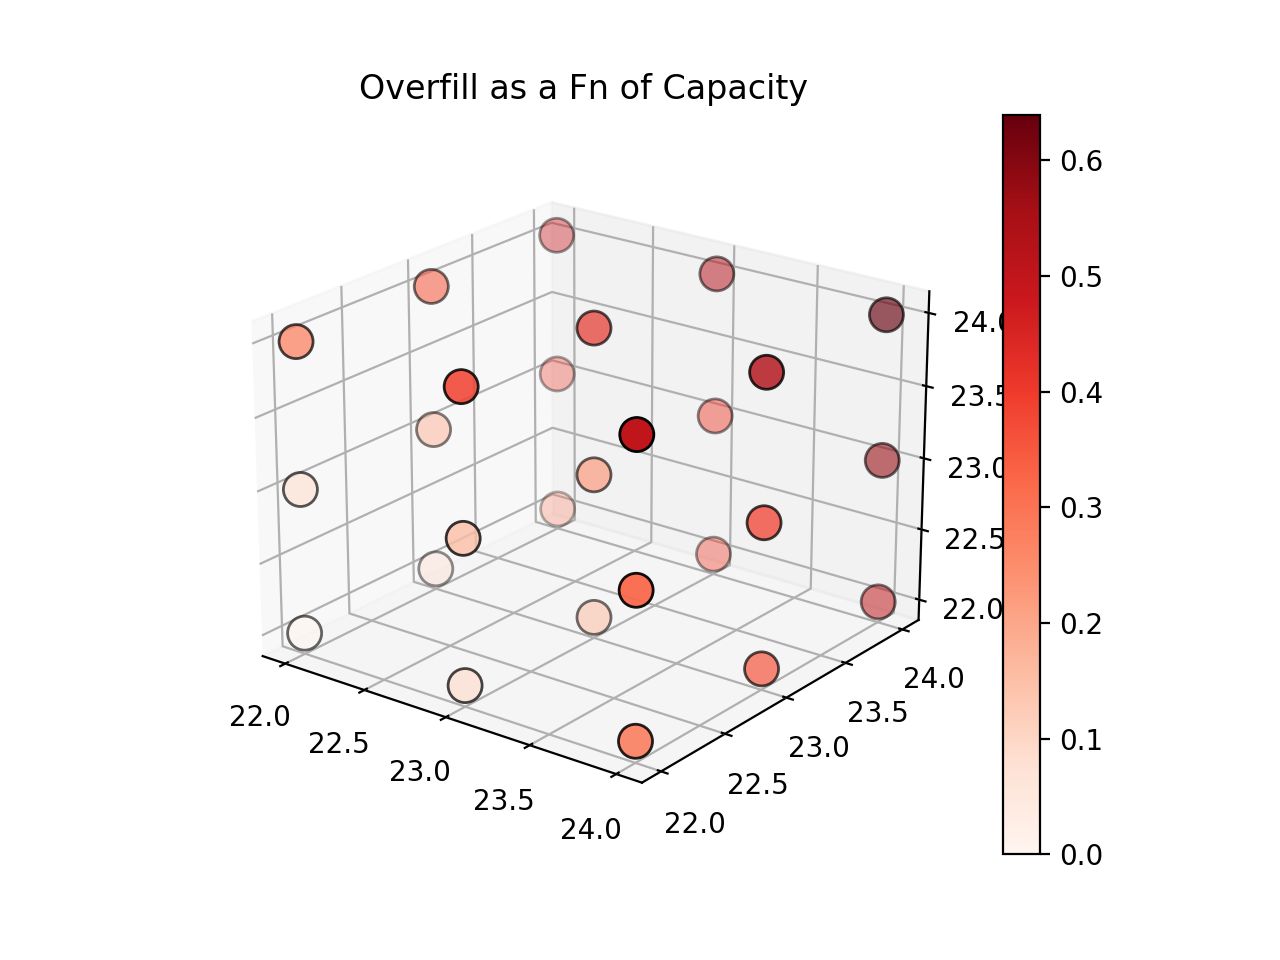

Text(0.5, 0.92, 'Overfill as a Fn of Capacity')

In [94]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
sc = ax.scatter(q1hat, q2hat, q3hat, s=150, c=overfill, cmap='Reds', edgecolors='black')
plt.colorbar(sc)
plt.title('Overfill as a Fn of Capacity')

_Context:_ MNL preferences, STB lotteries the only priority 

**TAKEAWAY:** Overfill increases as any school's capacity increases

&emsp;


<IPython.core.display.Javascript object>


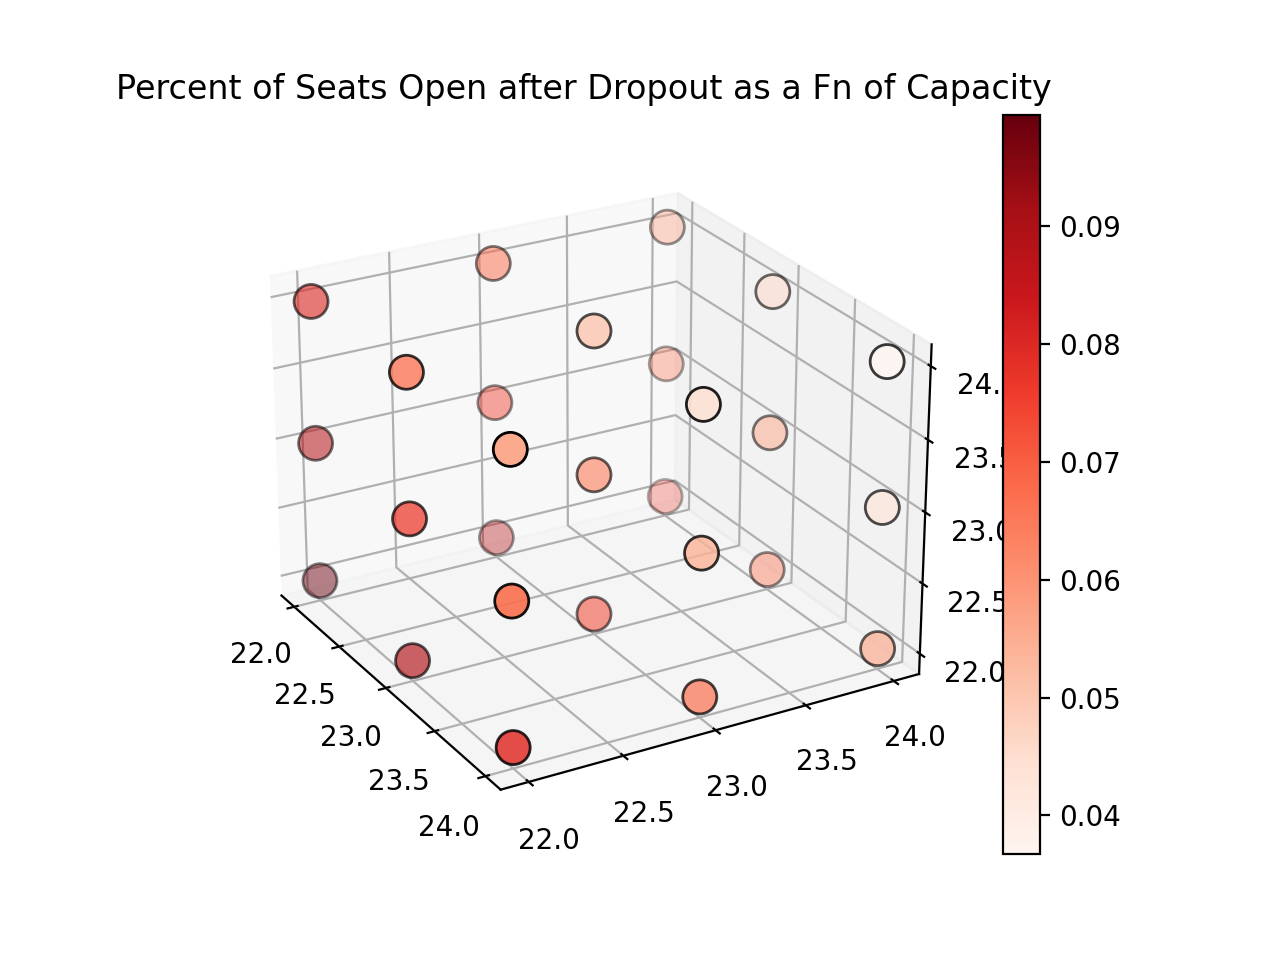

Text(0.5, 0.92, 'Percent of Seats Open after Dropout as a Fn of Capacity')

In [95]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
sc = ax.scatter(q1hat, q2hat, q3hat, s=150, c=pct_moving, cmap='Reds', edgecolors='black')
plt.colorbar(sc)
plt.title('Percent of Seats Open after Dropout as a Fn of Capacity')

**TAKEAWAY:** Percent of students moving is highest when school capacity is high, particularly for the most popular schoo. 